In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

In [1]:
# read nc output from WAOM 4km NOTIDE run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:45791' processes=28 threads=28>


In [3]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [4]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_notides_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
# HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
# HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
# Hvom = ds.variables["Hvom"] 
# Huon = ds.variables["Huon"] 

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

ds.close()


Vtransform=2
CPU times: user 8.48 s, sys: 2.67 s, total: 11.2 s
Wall time: 28.2 s


In [5]:
%%time

ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_notides_diag/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] 

ds.close()


CPU times: user 7.12 s, sys: 2.3 s, total: 9.42 s
Wall time: 20.5 s


In [6]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr9_notides/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=-1, two=0) # 5-days mean
ds.close()

    
tlen = len(temp[:,0,0,0])

CPU times: user 2.78 s, sys: 774 ms, total: 3.55 s
Wall time: 4.2 s


In [7]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
dt = 5*86400 # 5-days in seconds
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

(31, 1400, 1575, 73)
(31, 1400, 1575, 73)
(73, 31, 1400, 1575)
CPU times: user 652 ms, sys: 602 ms, total: 1.25 s
Wall time: 1.06 s


In [8]:
# calculate surface sigma_theta (potential density)
sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000

# load ice draft to create masks
di = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_notides_diag/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

In [23]:
# load horizontal diffusion of heat calculated online:
	# float temp_hdiff(ocean_time, s_rho, eta_rho, xi_rho) ;

ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_notides_diag/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
temp_hdiff = ds.variables["temp_hdiff"] 
temp_vdiff = ds.variables["temp_vdiff"] 
temp_hadv = ds.variables["temp_hadv"] 
temp_vadv = ds.variables["temp_vadv"] 
ds.close()

In [10]:
# check dimensions temp_rate x temp_hdiff (and other budget terms)!


print(temp_Rate.shape)
print(temp_hdiff.shape)


(73, 31, 1400, 1575)
(73, 31, 1400, 1575)


In [11]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'


In [12]:
contour_masked_above = np.load(files_path + 'WAOM4_contour_masked_above_1500m', allow_pickle=True)


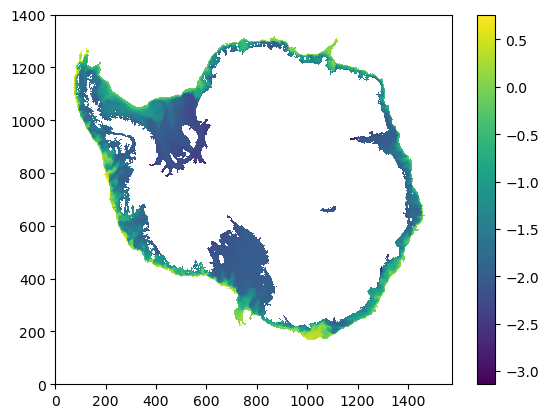

In [13]:
plt.pcolormesh(ma.masked_where(contour_masked_above == -1000, temp.isel(ocean_time=0, s_rho=0)))
plt.colorbar()

In [14]:
%%time
# method 2 to calculate Dz:
# z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.

Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
print(z_w.shape, Z_w.shape)
dz = np.diff(Z_w,axis=1)


(73, 1400, 1575, 32) (73, 32, 1400, 1575)
CPU times: user 31.9 s, sys: 1min 8s, total: 1min 40s
Wall time: 1min 42s


In [15]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC

In [16]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure*1
# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    shflux_masked = ma.masked_where(contour_masked_above == -1000, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.
    shflux_area = shflux_masked*area
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    #del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
    temp_rate_dz = temp_Rate[mm,:]*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vint_masked =  ma.masked_where(contour_masked_above == -1000, temp_rate_vint)
    temp_rate_vol[mm,:] = temp_rate_vint_masked*area
    
    #del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(ma.masked_where(contour_masked_above == -1000,temp_rate_vol[mm,:]),axis=1), axis=0)*Cp*rho0


CPU times: user 5min 5s, sys: 3min 11s, total: 8min 16s
Wall time: 11min 12s


In [17]:
%%time
# 3. heat tendency due to horizontal diffusion:
temp_hdiff_int = np.empty((tlen))
temp_hdiff_vol = np.empty(np.squeeze(temp_hdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hdiff_dz = temp_hdiff[mm,:]*dz[mm,:]
    temp_hdiff_vint = np.nansum(temp_hdiff_dz, axis=0)
    temp_hdiff_vint_masked =  ma.masked_where(contour_masked_above == -1000, temp_hdiff_vint)
    temp_hdiff_vol[mm,:] = temp_hdiff_vint_masked*area

    temp_hdiff_int[mm] = np.nansum(np.nansum(ma.masked_where(contour_masked_above == -1000,temp_hdiff_vol[mm,:]),axis=1), axis=0)*Cp*rho0


CPU times: user 3min 9s, sys: 2min 55s, total: 6min 5s
Wall time: 7min 8s


In [24]:
%%time
# 4. heat tendency due to vertical diffusion:
temp_vdiff_int = np.empty((tlen))
temp_vdiff_vol = np.empty(np.squeeze(temp_vdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vdiff_dz = temp_vdiff[mm,:]*dz[mm,:]
    temp_vdiff_vint = np.nansum(temp_vdiff_dz, axis=0)
    temp_vdiff_vint_masked =  ma.masked_where(contour_masked_above == -1000, temp_vdiff_vint)
    temp_vdiff_vol[mm,:] = temp_vdiff_vint_masked*area

    temp_vdiff_int[mm] = np.nansum(np.nansum(ma.masked_where(contour_masked_above == -1000,temp_vdiff_vol[mm,:]),axis=1), axis=0)*Cp*rho0


CPU times: user 3min 8s, sys: 2min 54s, total: 6min 2s
Wall time: 7min 5s


In [25]:
%%time
# 5. heat tendency due to horizontal advection:
temp_hadv_int = np.empty((tlen))
temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
    temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
    temp_hadv_vint_masked =  ma.masked_where(contour_masked_above == -1000, temp_hadv_vint)
    temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area

    temp_hadv_int[mm] = np.nansum(np.nansum(ma.masked_where(contour_masked_above == -1000,temp_hadv_vol[mm,:]),axis=1), axis=0)*Cp*rho0


CPU times: user 3min 5s, sys: 2min 56s, total: 6min 1s
Wall time: 6min 27s


In [26]:
%%time
# 6. heat tendency due to vertical advection:
temp_vadv_int = np.empty((tlen))
temp_vadv_vol = np.empty(np.squeeze(temp_vadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vadv_dz = temp_vadv[mm,:]*dz[mm,:]
    temp_vadv_vint = np.nansum(temp_vadv_dz, axis=0)
    temp_vadv_vint_masked =  ma.masked_where(contour_masked_above == -1000, temp_vadv_vint)
    temp_vadv_vol[mm,:] = temp_vadv_vint_masked*area

    temp_vadv_int[mm] = np.nansum(np.nansum(ma.masked_where(contour_masked_above == -1000,temp_vadv_vol[mm,:]),axis=1), axis=0)*Cp*rho0


CPU times: user 3min 1s, sys: 2min 59s, total: 6min 1s
Wall time: 6min 26s


In [27]:
# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

0.016921577453363996


In [28]:
temp_rate_vol.shape

(73, 1400, 1575)

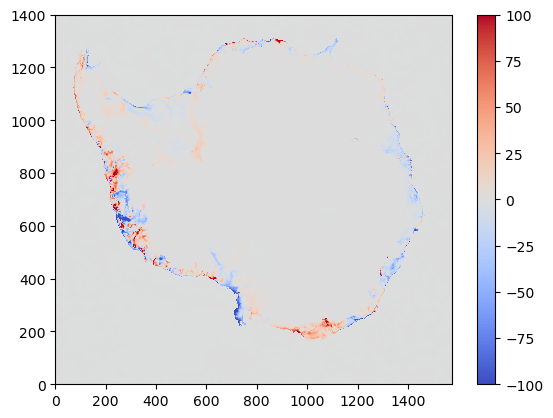

In [35]:
mm=35
# plt.pcolormesh(ma.masked_where(contour_masked_above == -1000,temp_rate_vol[mm,:]), vmin=-2e3, vmax=2e3, cmap='coolwarm')
plt.pcolormesh(np.nanmean(temp_rate_vol, axis=0), vmin=-1e2, vmax=1e2, cmap='coolwarm')
plt.colorbar()

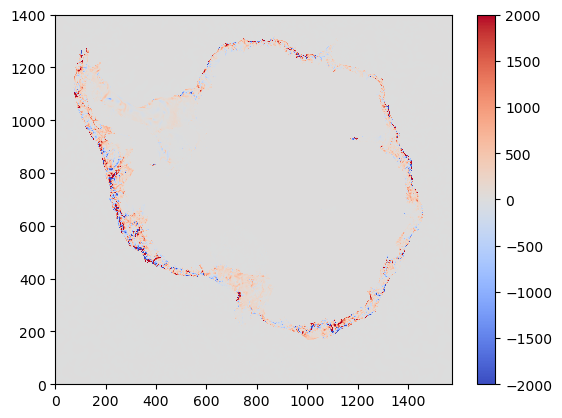

In [36]:
plt.pcolormesh(temp_rate_vol[-1,:], vmin=-2e3, vmax=2e3, cmap='coolwarm')
plt.colorbar()

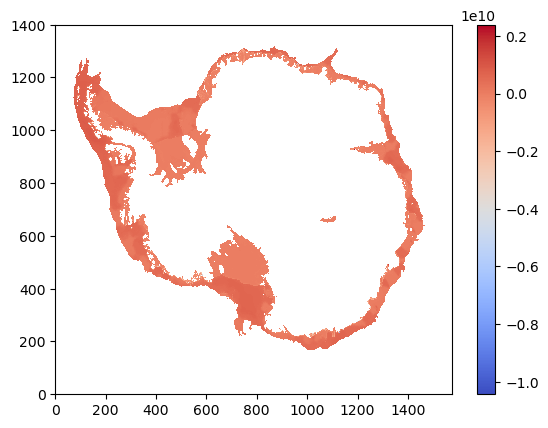

In [37]:
plt.pcolormesh(shflux_area, cmap='coolwarm')
plt.colorbar()

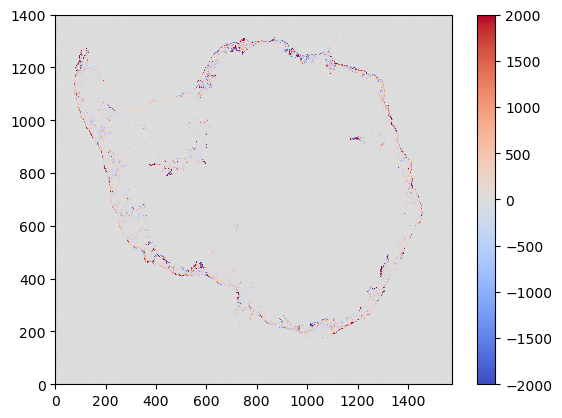

In [38]:
plt.pcolormesh(np.nanmean(temp_hdiff_vol,axis=0), vmin=-2e3, vmax=2e3, cmap='coolwarm')
plt.colorbar()

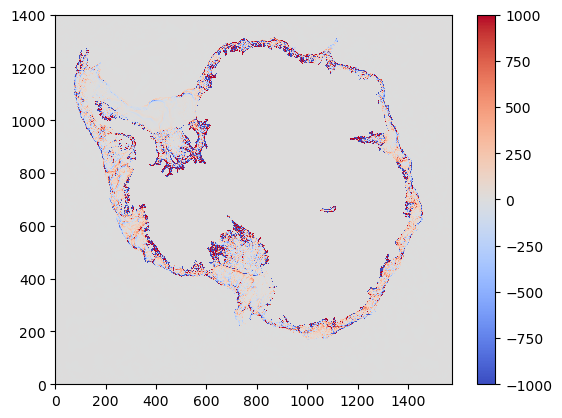

In [58]:
plt.pcolormesh(np.nanmean(temp_hadv_vol,axis=0), vmin=-1e3, vmax=1e3, cmap='coolwarm')
plt.colorbar()

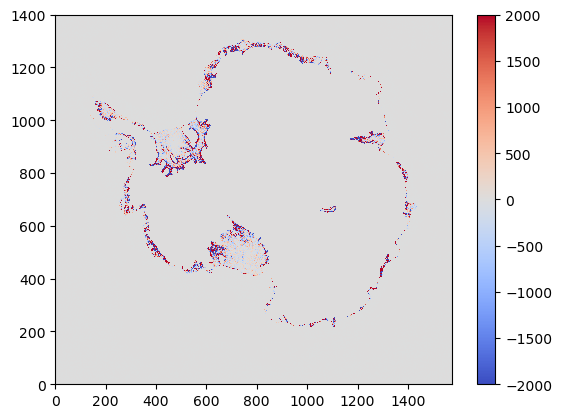

In [56]:
plt.pcolormesh(np.nanmean(temp_vadv_vol,axis=0), vmin=-2e3, vmax=2e3, cmap='coolwarm')
plt.colorbar()

In [61]:
# OHB integrated
print('OHC tendency annual avg (TW): ',np.nanmean(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nanmean(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.nanmean(temp_rate_int)-np.nanmean(shflux_int))*1e-12)
print('Horz. diffusion (TW): ',np.nanmean(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nanmean(temp_vdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nanmean(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nanmean(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nanmean(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)



OHC tendency annual avg (TW):  0.3265587971668656
Net sfc heat flux annual avg (TW):  -62.71683531388769
Residue (OHC - shflux) (TW):  63.04339411105456
Horz. diffusion (TW):  42.36548581832441
Vert. diffusion (TW):  -108.35402115949607
Horz. advection (TW):  -41.55276977633427
Vert. advection (TW):  110.0798746727346
Sum all above terms:  2.538569555228658


In [1]:
months=np.arange(0,73)*(1/(30.41667/5))
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(ncols=1, figsize = (10, 6))
plt.plot(months,shflux_int, label='Sfc heat flux', color='royalblue')
plt.plot(months,temp_rate_int, label='OHC tendency', color='darkorange')
# plt.plot(months,temp_hdiff_int, label='Horz. diffusion of heat', color='green')
plt.plot(months,temp_hdiff_int+temp_vdiff_int,'--', label='Total diffusion of heat', color='c')
plt.plot(months,temp_hadv_int, label='Horz. advection of heat',color='darkred')
plt.plot(months,temp_vadv_int, label='Vert. advection of heat',color='darkblue')
plt.plot(months,shflux_int*0,'--k')
plt.plot(months,temp_rate_int - shflux_int, '--r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=0.5, color='red')
plt.plot(months,temp_hadv_int + temp_vadv_int, '--r', label='horiz+vert advection',linewidth=0.5, color='limegreen')
plt.plot(months,all_rhs, '--m', label='all RHS',linewidth=1)
plt.ylim([-2e14,2e14])
# print annual avg values:
plt.text(10.2,-.5e14,str(np.round(np.mean(shflux_int)*1e-12,decimals=4)) + 'TW', color='royalblue')
plt.text(10.2,1.65e14,str(np.round(np.mean(temp_rate_int)*1e-12,decimals=4)) + 'TW', color='darkorange')
plt.text(9.2,1.1e14,str(np.round(np.mean(temp_rate_int - shflux_int)*1e-12,decimals=4)) + 'TW', color='red')
# plt.text(10.2,1.35e14,str(np.round(np.mean(temp_hdiff_int)*1e-12,decimals=4)) + 'TW', color='green')
plt.text(10.9,-.35e14,str(np.round(np.mean(temp_hadv_int)*1e-12,decimals=4)) + 'TW', color='darkred')
plt.text(9,.8e14,str(np.round(np.mean(temp_vadv_int)*1e-12,decimals=4)) + 'TW', color='darkblue')


plt.grid()
plt.legend()
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM4-NOTIDE')


name_fig='WAOM4-notides_OHB_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

NameError: name 'np' is not defined